In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### build the dataset

In [5]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.dtype, X.shape, Y.dtype, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.int64 torch.Size([182625, 3]) torch.int64 torch.Size([182625])
torch.int64 torch.Size([22655, 3]) torch.int64 torch.Size([22655])
torch.int64 torch.Size([22866, 3]) torch.int64 torch.Size([22866])


In [6]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update gradient
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8341
  20000/ 200000: 2.5523
  30000/ 200000: 2.8717
  40000/ 200000: 2.0855
  50000/ 200000: 2.5842
  60000/ 200000: 2.4150
  70000/ 200000: 2.1321
  80000/ 200000: 2.3674
  90000/ 200000: 2.3077
 100000/ 200000: 2.0464
 110000/ 200000: 2.4816
 120000/ 200000: 1.9383
 130000/ 200000: 2.4820
 140000/ 200000: 2.1662
 150000/ 200000: 2.1765
 160000/ 200000: 2.0685
 170000/ 200000: 1.7901
 180000/ 200000: 2.0546
 190000/ 200000: 1.8380


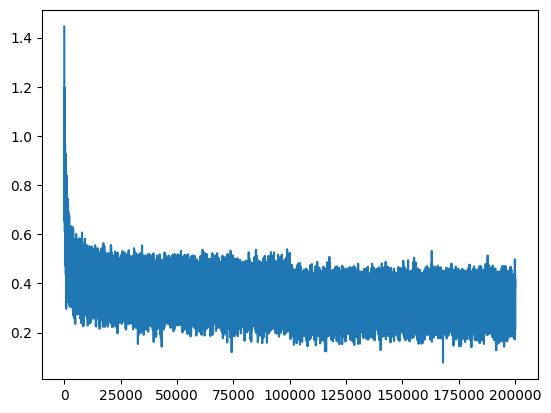

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte)}[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.125401020050049
val 2.1713311672210693


### expected loss at initialization

In [21]:
F.cross_entropy(torch.ones(27), torch.tensor(1))

tensor(3.2958)

### re-initialize the weights - lower the weight values

In [22]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update gradient
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


In [25]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y = {'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte)}[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310746669769287


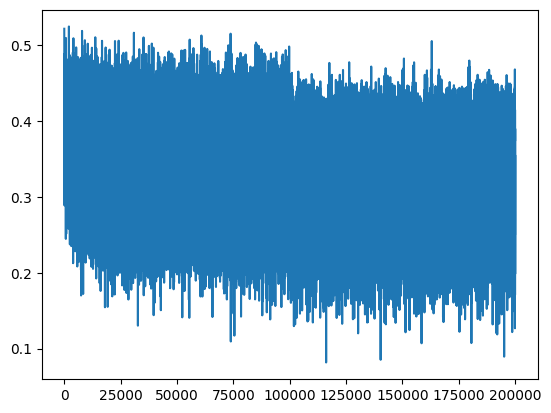

In [24]:
plt.plot(lossi)

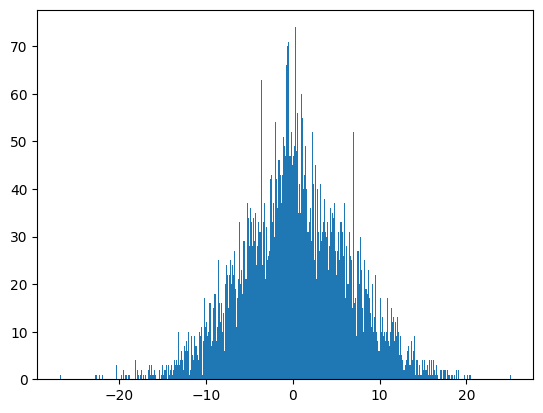

In [39]:
plt.hist(hpreact.view(-1).tolist(), 500);

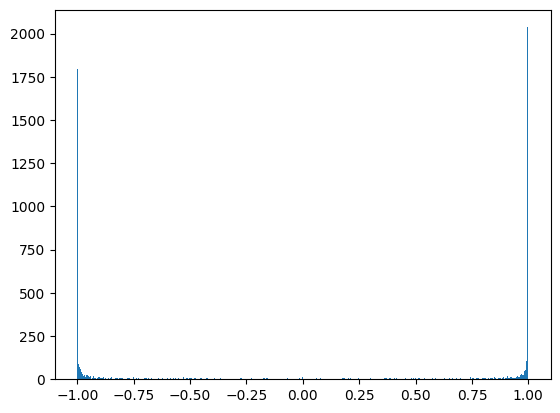

In [40]:
plt.hist(h.view(-1).tolist(), 500);

/tmp/ipykernel_10214/456097638.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.linspace(-5, 5, 100).tolist(), torch.tanh(torch.tensor(torch.linspace(-5, 5, 100))).tolist())


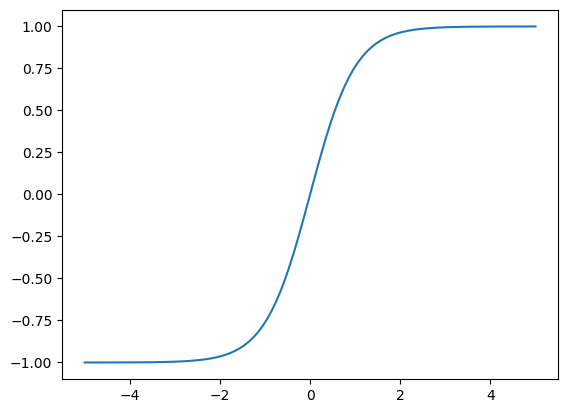

In [30]:
plt.plot(torch.linspace(-5, 5, 100).tolist(), torch.tanh(torch.tensor(torch.linspace(-5, 5, 100))).tolist())

In [38]:
torch.arctanh(torch.tensor(0.99))

tensor(2.6467)

### sample from the model

In [12]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (N, block_size, n_embed)
        embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embed)
        h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break # break on '.'
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nah.
yam.
rensleighdrae.
caileed.
elin.
shy.
jen.
eden.
estanaraelyn.
malke.
cayshuberlyni.
jest.
jair.
jenipanthono.
ubelleda.
kylynn.
els.


In [ ]:
C = torch.randn((27,2))

In [ ]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

In [ ]:
print(X.shape)
print(C[X].shape)
print(Y.shape)
print(C[Y].shape)

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
print(W1.shape, b1.shape)

In [ ]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h.shape)

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
print(loss.item())

In [ ]:
print(F.cross_entropy(logits, Y))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters)

In [ ]:
lr = 0.1
for _ in range(100):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

### build full dataset

In [ ]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.dtype, X.shape, Y.dtype, Y.shape)
    return X, Y

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

### gradient descent

In [ ]:
lr = 0.1
X, Y = build_dataset(words)
for epoch in range(100):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

### gradient descent on mini batch
### first select a range for learning rate

In [ ]:
lre = torch.linspace(torch.log10(torch.tensor(0.001)), torch.log10(torch.tensor(1.0)), 1000)
lrs = 10**lre
print(torch.vstack((lre, lrs)).transpose(1, 0))
plt.plot(lre, lrs)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

### train with the selected learning rate values

In [ ]:
lossi = []
lri = []
for epoch in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    lossi.append(loss.item())
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    lri.append(lre[epoch])
    lr = lrs[epoch]
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

### plot the learning rate and the loss to determine the best learning rate

In [ ]:
plt.plot(lri, lossi)

### above plot shows that value bw -1.0 and -0.5, for example -0.75 is probably a good learning rate
### train with the selected learning rate

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
lossi = []
lr = 10**-0.9 # learning rate 10^(-1.25)
print(f'{lr=}')
for epoch in range(1000):
    # ix = torch.randint(0, X.shape[0], (X.shape[0],))
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    lossi.append(loss.item())
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

In [ ]:
print(len(lossi))
plt.plot(np.arange(len(lossi)).tolist(), lossi)

### dataset split: training set, validation set, testing set
### 80%, 10%, 10%

In [ ]:
# words = open('names.txt', 'r').read().splitlines()
# print(len(words))
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(n1, n2-n1, len(words)-n2)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

### train only with training set

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

In [ ]:
lossi = []
lr = 10**-1.25 # learning rate 10^(-1.25)
lr = 0.1
print(f'{lr=}')
for epoch in range(40000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    lossi.append(loss.item())
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

### compute the loss on training and validation/development set

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

### increase the n/w size

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
stepi = []
lossi = []
lr = 10**-1.25 # learning rate 10^(-1.25)
lr = 0.1/2
print(f'{lr=}')
for step in range(30000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    stepi.append(step)
    lossi.append(loss.item())
    # print(step, loss.item())    
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

### increase the n/w size

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
stepi = []
lossi = []
lr = 10**-1.25 # learning rate 10^(-1.25)
lr = 0.01
print(f'{lr=}')
for step in range(30000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    stepi.append(step)
    lossi.append(loss.item())
    # print(step, loss.item())    
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())